In [1]:
import os
import librosa
import numpy as np

# 오디오 설정
SAMPLE_RATE = 16000
FRAME_SIZE = 1024
HOP_LENGTH = 512

def extract_freq_amp_phase(frame, sr):
    stft = librosa.stft(frame, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    magnitude, phase = np.abs(stft), np.angle(stft)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=FRAME_SIZE)
    dominant_bin = np.argmax(magnitude[:, 0])
    freq = freqs[dominant_bin]
    amp = np.mean(magnitude[dominant_bin])
    phase_val = phase[dominant_bin][0]
    return np.array([freq, amp, phase_val])

def extract_features_from_file(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)
    features = []
    for i in range(0, len(y) - FRAME_SIZE, HOP_LENGTH):
        frame = y[i:i+FRAME_SIZE]
        feat = extract_freq_amp_phase(frame, sr)
        features.append(feat)
    return np.array(features)

# 모든 .wav 파일에서 특성 추출
def extract_all_features(wav_dir="./wav"):
    all_features = []
    for filename in os.listdir(wav_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(wav_dir, filename)
            print(f"📂 Processing: {filename}")
            feats = extract_features_from_file(file_path)
            all_features.append(feats)
    return np.vstack(all_features)  # 모든 파일의 결과를 하나로 합침

# 사용 예
features = extract_all_features()
print("✅ 전체 특성 shape:", features.shape)  # (전체 프레임 수, 3)

📂 Processing: noise1.wav
📂 Processing: noise10.wav
📂 Processing: noise100.wav
📂 Processing: noise1000.wav
📂 Processing: noise1001.wav
📂 Processing: noise1002.wav
📂 Processing: noise1003.wav
📂 Processing: noise1004.wav
📂 Processing: noise1005.wav
📂 Processing: noise1006.wav
📂 Processing: noise1007.wav
📂 Processing: noise1008.wav
📂 Processing: noise1009.wav
📂 Processing: noise101.wav
📂 Processing: noise1010.wav
📂 Processing: noise1011.wav
📂 Processing: noise1012.wav
📂 Processing: noise1013.wav
📂 Processing: noise1014.wav
📂 Processing: noise1015.wav
📂 Processing: noise1016.wav
📂 Processing: noise1017.wav
📂 Processing: noise1018.wav
📂 Processing: noise1019.wav
📂 Processing: noise102.wav
📂 Processing: noise1020.wav
📂 Processing: noise1021.wav
📂 Processing: noise1022.wav
📂 Processing: noise1023.wav
📂 Processing: noise1024.wav
📂 Processing: noise1025.wav
📂 Processing: noise1026.wav
📂 Processing: noise1027.wav
📂 Processing: noise1028.wav
📂 Processing: noise1029.wav
📂 Processing: noise103.wav
📂

In [2]:
import numpy as np

def create_sequences(features, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]      # 입력: 5프레임 (window)
        seq_y = features[i+window_size]        # 출력: 다음 프레임
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# 이전 단계에서 features = (전체 프레임 수, 3)
X, y = create_sequences(features, window_size=5)

print("X shape:", X.shape)  # (샘플 수, 5, 3)
print("y shape:", y.shape)  # (샘플 수, 3)

X shape: (82375, 5, 3)
y shape: (82375, 3)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# X: (samples, 5, 3), y: (samples, 3) 형태라고 가정

def preprocess_and_scale(X, y):
    # 1. X reshape: (samples, 5, 3) -> (samples, 15)
    X_reshaped = X.reshape(X.shape[0], -1)

    # 2. MinMaxScaler 생성 및 적합
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # 3. X, y 스케일링
    X_scaled = scaler_x.fit_transform(X_reshaped)
    y_scaled = scaler_y.fit_transform(y)

    # 4. X 다시 reshape: (samples, 15) -> (samples, 5, 3)
    X_scaled = X_scaled.reshape(X.shape)

    # 5. 스케일러 저장
    joblib.dump(scaler_x, "scaler_x.joblib")
    joblib.dump(scaler_y, "scaler_y.joblib")

    print(f"✅ X 정규화 완료: {X_scaled.shape}")
    print(f"✅ y 정규화 완료: {y_scaled.shape}")

    return X_scaled, y_scaled, scaler_x, scaler_y

# 사용 예시
X_scaled, y_scaled, scaler_x, scaler_y = preprocess_and_scale(X, y)


✅ X 정규화 완료: (82375, 5, 3)
✅ y 정규화 완료: (82375, 3)


In [ ]:
import tensorflow as tf # typing: ignore
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # typing: ignore
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add # typing: ignore
from tensorflow.keras.callbacks import EarlyStopping # typing: ignore

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)  # (5, 3)

    # Multi-Head Attention 블록
    attn = MultiHeadAttention(num_heads=2, key_dim=16)(inputs, inputs)
    attn = Dropout(0.1)(attn)
    x = Add()([inputs, attn])
    x = LayerNormalization()(x)

    # Feed Forward 블록
    ff = Dense(64, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(3)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # 평균 풀링으로 시퀀스 축소
    x = tf.reduce_mean(x, axis=1)  # (batch_size, 3)

    outputs = Dense(3)(x)  # [freq, amp, phase] 회귀 출력
    model = Model(inputs, outputs)
    return model

# 모델 생성
model = build_transformer_model(input_shape=(5, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 학습
history = model.fit(
    X_scaled, y_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # MAE 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 모델 저장
model.save("transformer_estimator.h5")
print("✅ 모델 저장 완료: transformer_estimator.h5")

515/515 [==============================] - 2s 4ms/step - loss: 0.0352 - mae: 0.1190
Test Loss (MSE): 0.0352, Test MAE: 0.1190
515/515 [==============================] - 2s 3ms/step


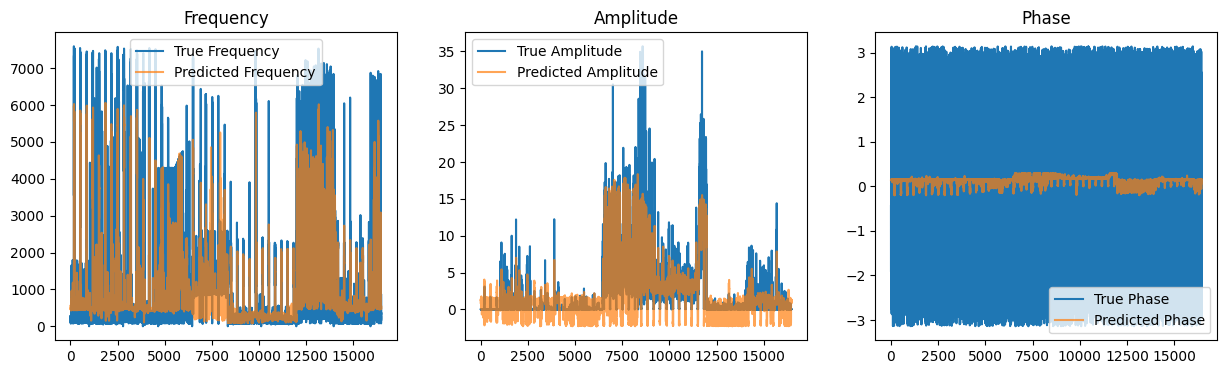

In [11]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model # typing: ignore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def create_sequences(features, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]
        seq_y = features[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 1. features 배열 준비 (예: ./wav 처리 후 추출된 freq, amp, phase 배열)
# features = ...

# 2. train/test 분리 (예: 80% 학습, 20% 테스트)
train_features, test_features = train_test_split(features, test_size=0.2, shuffle=False)

# 3. 시퀀스 생성
X_train, y_train = create_sequences(train_features, window_size=5)
X_test, y_test = create_sequences(test_features, window_size=5)

# 4. 스케일러 불러오기 (학습 때 저장한 파일)
scaler_x = joblib.load("scaler_x.joblib")
scaler_y = joblib.load("scaler_y.joblib")

# 5. 스케일링 적용
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_scaled = scaler_x.transform(X_test_reshaped).reshape(X_test.shape)

y_test_scaled = scaler_y.transform(y_test)

# 6. 모델 불러오기
model = load_model("transformer_estimator.h5")

# 7. 모델 평가
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# 8. 예측 및 역정규화
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# 9. 결과 시각화
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.plot(y_true[:,0], label='True Frequency')
plt.plot(y_pred[:,0], label='Predicted Frequency', alpha=0.7)
plt.title('Frequency')
plt.legend()

plt.subplot(1,3,2)
plt.plot(y_true[:,1], label='True Amplitude')
plt.plot(y_pred[:,1], label='Predicted Amplitude', alpha=0.7)
plt.title('Amplitude')
plt.legend()

plt.subplot(1,3,3)
plt.plot(y_true[:,2], label='True Phase')
plt.plot(y_pred[:,2], label='Predicted Phase', alpha=0.7)
plt.title('Phase')
plt.legend()

plt.show()


In [ ]:
import numpy as np
import sounddevice as sd
import time

SAMPLE_RATE = 16000
FRAME_SIZE = 512
DURATION = FRAME_SIZE / SAMPLE_RATE

def extract_freq_amp_phase(frame, sr):
    fft = np.fft.rfft(frame, n=FRAME_SIZE)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    freqs = np.fft.rfftfreq(FRAME_SIZE, 1/sr)

    magnitude[0] = 0  # DC 성분 제거

    dominant_bin = np.argmax(magnitude)
    freq = freqs[dominant_bin]
    amp = magnitude[dominant_bin]
    phase_val = phase[dominant_bin]

    return np.array([freq, amp, phase_val], dtype=np.float32)

def generate_wave(freq, amp, phase, duration, sr):
    # 유효한 주파수만 반응 (20~1000Hz)
    if freq < 20 or freq > 1000:
        return np.zeros(int(sr * duration), dtype=np.float32)
    
    # 진폭 제한
    amp = np.clip(amp, -0.05, 0.05)

    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    wave = amp * np.sin(2 * np.pi * freq * t + phase)
    return wave.astype(np.float32)

def audio_callback(indata, outdata, frames, time, status):
    if status:
        print(f"Status: {status}")

    mono = indata[:, 0]
    freq, amp, phase = extract_freq_amp_phase(mono, SAMPLE_RATE)

    # 위상 반전한 파형 생성
    anti_wave = generate_wave(freq, amp, phase + np.pi, DURATION, SAMPLE_RATE)
    anti_wave = anti_wave[:frames].reshape(-1, 1)
    anti_wave = np.clip(anti_wave, -1, 1)

    outdata[:] = anti_wave

    # 디버깅 출력
    print(f"↩️ 반대파 생성: freq={freq:.2f}Hz, amp={amp:.5f}, max={anti_wave.max():.4f}, min={anti_wave.min():.4f}")

print("🎙️ 실시간 위상 반전 노이즈 캔슬링 시작 (Ctrl+C로 종료)")

with sd.Stream(channels=1, callback=audio_callback, samplerate=SAMPLE_RATE, blocksize=FRAME_SIZE):
    while True:
        time.sleep(0.1)

In [15]:
import numpy as np
import sounddevice as sd
import time
import tensorflow as tf
import joblib

SAMPLE_RATE = 16000
FRAME_SIZE = 1024
DURATION = FRAME_SIZE / SAMPLE_RATE

model = tf.keras.models.load_model("transformer_estimator.h5")
scaler_x = joblib.load("scaler_x.joblib")
scaler_y = joblib.load("scaler_y.joblib")

frame_history = []

def extract_freq_amp_phase(frame, sr):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    freqs = np.fft.rfftfreq(len(frame), 1/sr)

    dominant_bin = np.argmax(magnitude[1:]) + 1
    freq = freqs[dominant_bin]
    amp = magnitude[dominant_bin] / len(frame) * 2
    phase_val = phase[dominant_bin]
    return np.array([freq, amp, phase_val], dtype=np.float32)

def generate_wave(freq, amp, phase, duration, sr):
    if freq < 20 or freq > 1000:
        return np.zeros(int(sr * duration), dtype=np.float32)

    amp = np.clip(amp, -0.1, 0.1)
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    wave = amp * np.sin(2 * np.pi * freq * t + phase)
    return wave.astype(np.float32)

def audio_callback(indata, outdata, frames, time_info, status):
    global frame_history
    if status:
        print("Status:", status)

    mono = indata[:, 0]
    current = extract_freq_amp_phase(mono, SAMPLE_RATE)
    frame_history.append(current)

    if len(frame_history) < 5:
        outdata[:] = mono.reshape(-1, 1)
        return
    if len(frame_history) > 5:
        frame_history.pop(0)

    # 모델 입력
    input_seq = np.array(frame_history).reshape(1, 5, 3)
    input_seq_scaled = scaler_x.transform(input_seq.reshape(1, -1)).reshape(1, 5, 3)
    correction_scaled = model.predict(input_seq_scaled, verbose=0)[0]
    delta_freq, delta_amp, delta_phase = scaler_y.inverse_transform(correction_scaled.reshape(1, -1))[0]

    # 기본 반대파
    base_wave = generate_wave(current[0], current[1], current[2] + np.pi, DURATION, SAMPLE_RATE)

    # 모델 보정값 반영
    corrected_freq = current[0] + delta_freq
    corrected_amp = current[1] + delta_amp
    corrected_phase = current[2] + delta_phase + np.pi
    correction_wave = generate_wave(corrected_freq, corrected_amp, corrected_phase, DURATION, SAMPLE_RATE)

    # 두 반대파 합산
    anti_wave = base_wave + correction_wave
    anti_wave = np.clip(anti_wave, -1, 1)

    # 출력 (실제 입력과 반대파 섞기)
    blend_ratio = 0.7
    mixed = (1 - blend_ratio) * mono[:frames] + blend_ratio * anti_wave[:frames]
    outdata[:] = mixed.reshape(-1, 1)

    print(f"[base] f={current[0]:.2f}, a={current[1]:.4f}, p={current[2]:.2f} | "
          f"[delta] ∆f={delta_freq:.2f}, ∆a={delta_amp:.4f}, ∆p={delta_phase:.2f}")

print("🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)")
with sd.Stream(channels=1, callback=audio_callback, samplerate=SAMPLE_RATE, blocksize=FRAME_SIZE):
    while True:
        time.sleep(0.1)


🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)
[base] f=15.62, a=0.0260, p=-0.81 | [delta] ∆f=410.47, ∆a=1.8497, ∆p=0.16
Status: input overflow, output underflow
[base] f=15.62, a=0.0442, p=-2.60 | [delta] ∆f=406.99, ∆a=1.9019, ∆p=0.16
[base] f=62.50, a=0.0212, p=-2.45 | [delta] ∆f=406.66, ∆a=1.8859, ∆p=0.16
Status: input overflow, output underflow
[base] f=125.00, a=0.0672, p=-1.56 | [delta] ∆f=427.88, ∆a=1.6436, ∆p=0.16
[base] f=125.00, a=0.0783, p=-0.96 | [delta] ∆f=440.17, ∆a=1.4727, ∆p=0.15
[base] f=125.00, a=0.0649, p=-0.47 | [delta] ∆f=446.47, ∆a=1.4391, ∆p=0.15
[base] f=15.62, a=0.0298, p=0.48 | [delta] ∆f=437.52, ∆a=1.5126, ∆p=0.15
[base] f=15.62, a=0.0298, p=-1.58 | [delta] ∆f=434.15, ∆a=1.5187, ∆p=0.15
[base] f=15.62, a=0.0347, p=1.74 | [delta] ∆f=414.47, ∆a=1.6916, ∆p=0.16
[base] f=62.50, a=0.0257, p=0.91 | [delta] ∆f=405.02, ∆a=1.7412, ∆p=0.16
[base] f=15.62, a=0.0356, p=-1.42 | [delta] ∆f=399.22, ∆a=1.8033, ∆p=0.16
[base] f=15.62, a=0.0382, p=-2.32 | [delta] ∆f=405.05, ∆a=1.8085, ∆p=0.16
[

KeyboardInterrupt: 